# Quantiles

https://machinelearningmastery.com/curve-fitting-with-python/

https://study.com/academy/lesson/interpolation-in-statistics-definition-formula-example.html

In [3]:
import time
import pandas as pd

import numpy as np

from numpy import corrcoef as pcor

from numpy import exp as exp
from scipy import spatial

from itertools import combinations

import pickle

from datetime import datetime, timedelta
import random
import glob


import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
def return_best_shapelet_pearson(vector):
    correlation_lst = []
    corrs = []
    for i in range(len(shapelet_standard_array)):
        score = similarity_metrix(shapelet_standard_array[i],vector)
        correlation_lst.append(shapelet_standard_names[i])
        corrs.append(score)
    scenario = corrs.index(max(corrs))
    return correlation_lst[scenario]

    
def return_all_shapelet_pearson(vector):
#     correlation_lst = []
    corrs = []
    for i in range(len(shapelet_standard_array)):
        score = similarity_metrix(shapelet_standard_array[i],vector)
#         correlation_lst.append(shapelet_standard_names[i])
        corrs.append(score)
    return corrs



def similarity_metrix(vector1,vector2):
    '''
    Here we have given user the flexibility to change the similarity function. Currently we have made it pearson correlation but it can be cosine
    
    1 - spatial.distance.cosine(vector1, vector2)
    '''
    similarity_value = round(pcor(vector1,vector2)[0][1],3)
    return similarity_value



In [47]:
Runtype = "Cases"#### choose Deaths for generating results for deaths and Cases for generating case results
Evaluation_files_github  ='../Data_Sources/Evaluation/'

if Runtype =='Cases':
    print("Process will run for Cases")

    Input_path = '../Data_Sources/Cases/'

    Ouput_path = '../Data_Sources/Cases/Output_Files/'

    Actual_incidence_path = Input_path+"/Input_Files/Actual_Incidence_Data/"

    pickle_path = Input_path+"Pickle_Objects/"

    Visualization_path = Input_path+"Visualizations/"
else:
    print("Process will run for Deaths")
    Input_path = '../Data_Sources/Deaths/'

    Ouput_path = '../Data_Sources/Deaths/Output_Files/'

    Actual_incidence_path = Input_path+"/Input_Files/Actual_Incidence_Data/"

    pickle_path = Input_path+"Pickle_Objects/"

    Visualization_path = Input_path+"Visualizations/"




Process will run for Cases


In [4]:
export_visualizations = False ### when this is set to True, visualizations will be expored. If False, visualizations will only be displayed not exported
Data_refresh = 0 

# Smoothening_param= 3 ### make it dynamic in code below 


### if it is set to 1, data processing of all models needs to be done. As is this needs to be set1 when we feel model data need to be updated else 0


#### Ignore model List 
Ignore_model_list  = []

Ignore_State_list = ['Illinois', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon','United States','Washington',
       'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Wyoming', 'Alaska', 'Maine',
       'Alabama', 'Idaho', 'Montana', 'Puerto Rico', 'Virgin Islands',
       'Guam', 'West Virginia', 'Northern Mariana Islands',
       'American Samoa']

# select_state_list = ["Florida"]

# State_list = ["Florida"]


vector_length = (0,4)   ### 1 means using N-1 week value for defining shapelet and 4 weeks 4 weeks from future. 4 can't be changed because models generate only 4 weeks ahead predictions.
## (0,4) means look 4 weeks ahead in future while defining shapelet
## (1,4) means look 4 weeks ahead in future, 1 week in past basically N-1 week from actual covid incidence list for defining shapelet

history_weeks = vector_length[0]

future_weeks = vector_length[1]

assert future_weeks<=4,"Looking 4 weeks in future is fixed because our modelsgenerate 4 weeks ahead predictions. \n Please change vector_length[1]"


Number_of_shapelets = 6 ### 6 

global Shapelet_length
Shapelet_length = vector_length[0]+vector_length[1]

shapelet_standard_array = [[0]*Shapelet_length for w in range(Number_of_shapelets)]
## here we have initialized an zero valued array of array.


# Hyper Params 

shapelet_standard_names = ["Flat","Inc",'Dec',"Surge",'Peaking',"Near Peak"]

assert len(shapelet_standard_names)==Number_of_shapelets, 'Size of array mismatch for shapelet_standard_names and value of  Number_of_shapelets'
# print('Size Mismacth')

### for this experiment, we have defined following shapelets 
# flat = [1.0, 1.00000001, 1.00000002, 1.00000003, 1.00000004]
# stable_inc = [1 ,2, 3, 4, 5]#, i.e., linear
# stable_dec = [5, 4, 3 ,2, 1]#, i.e., linear but decreasing
# surge =[exp(-1/2), exp(0/2), exp(1/2), exp(2/2), exp(3/2)]#, i.e., like exp(x)
# peaking = [-1*w for w in [exp(1/2) ,exp(0/2), exp(-1/2), exp(-2/2), exp(-3/2)]]#, i.e., like -exp(-x)
# at_near_peak=  [-1*w for w in [exp(-1/2) ,exp(0/2) ,exp(1/2) ,exp(2/2), exp(3/2)]]#, i.e., like -exp(x)

shapelet_standard_array[0] = [1.0, 0, 1.0, 0.0000]
shapelet_standard_array[1] = [1 ,2, 3, 4]
shapelet_standard_array[2] = [5, 4, 3 ,2]
shapelet_standard_array[3] = [1,2,4,8]
shapelet_standard_array[4] = [-1*w for w in [exp(1/2) ,exp(0/2), exp(-1/2), exp(-2/2)]]
shapelet_standard_array[5] = [-1*w for w in [exp(-1/2) ,exp(0/2) ,exp(1/2) ,exp(2/2)]]

assert len(shapelet_standard_array[0])==Shapelet_length, 'Size of defined shapelet array mismatch for shapelet_standard_names and value of  Shapelet_length.please check vector_length'



In [5]:

def valid_week_nbr(a_string):

    if [int(word) for word in a_string.split() if word.isdigit()][0]<5:
        return 1
    else:
        return 0
def interpolate(test_array):
    inter_list= []
    array_x = [w[0] for w in test_array]
    array_y = [w[1] for w in test_array]
#     sum_iter = 0
    for i in range(10):
        value_x = np.random.uniform(low=0.0, high=1.0)
        y_inter = np.interp(value_x,array_x,array_y)
        inter_list.append(round(y_inter,2))
    return inter_list
def return_Similarity_score_all(x):
    try:
    #     print(x[0][0])
    #     frst_week = []
        for item in x:
            if item[0].find("1")>-1:
                frst_week=item[1]
                break
        second_week = []
        for item in x:
            if item[0].find("2")>-1:
                second_week=item[1]
                break
        thrd_week =[]
        for item in x:
            if item[0].find("3")>-1:
                thrd_week=item[1]
                break
        frth_week=[]
        for item in x:
            if item[0].find("4")>-1:
                frth_week=item[1]
                break
        interpolated_array = []


        for i in range(len(frst_week)):
            vector = [frst_week[i],second_week[i],thrd_week[i],frth_week[i]]
    #         print(vector)
            interpolated_array.append(return_all_shapelet_pearson(vector))


        return interpolated_array
    except:
        return "NAN"
    
def aggregated_similarity(data):
    try:
        a = np.array(data)

        aggs = a.mean(axis=0)

        xx = [round(w,4) for w in aggs]
        return xx
    except:
        print(data)
    
from datetime import date


d0 = date(2020, 1, 22)

def format_dt_int(w):
    wsplit = w.split("-")
    yr = int(wsplit[0])
    mth=int(wsplit[1])
    dt = int(wsplit[2])
    d1 = date(yr, mth, dt)
    delta = d1 - d0
    return delta.days

import math
def is_valid(x):
    for i in x:
        if math.isnan(i):
            return 0
    return 1             


In [6]:
Source_path = "../Data_Sources/quantile_preprocessing/"

In [7]:
locatoins = pd.read_csv(Source_path+"locations.csv")

In [8]:
location_mapping = locatoins[['location','location_name']].set_index("location").to_dict()['location_name']

In [10]:
location_mapping['US']='United States'

In [11]:
#model_name = 'CEID-Walk'

runtype = "case"

valid_vals = ['US',	 '01',	 '02',	 '04',	 '05',	 '06',	 '08',	 '09',	 '10',	 '11',	 '12',	 '13',	 '15',	 '16',	 '17',	 '18',	 '19',	 '20',	 '21',	 '22',	 '23',	 '24',	 '25',	 '26',	 '27',	 '28',	 '29',	 '30',	 '31',	 '32',	 '33',	 '34',	 '35',	 '36',	 '37',	 '38',	 '39',	 '40',	 '41',	 '42',	 '44',	 '45',	 '46',	 '47',	 '48',	 '49',	 '50',	 '51',	 '53',	 '54',	 '55',	 '56',	 '60',	 '66',	 '69',	 '72',	 '74',	 '78']


In [12]:
## Load source files

In [13]:
#path = Source_path+"2020-08-09-CEID-Walk.csv"

In [14]:
#test_file = pd.read_csv(Source_path+"2020-08-09-CEID-Walk.csv")

In [15]:
# path = "/Users/satwant/Downloads/CEID-Walk/"

root = '/Users/satwant/Downloads/covid19-forecast-hub-master/data-processed'

In [16]:
model_root = glob.glob(root+"/*")

In [19]:
model_root[0]

'UCSB-ACTS'

In [22]:
filenames

[]

In [23]:

valid_models = ["COVIDhub-4_week_ensemble","RobertWalraven-ESG",	"CU-nochange",	"CU-scenario-low",	"JHUAPL-Bucky",	"JHU-IDD-CovidSP",	"CU-scenario-mid",	"COVIDhub-baseline",	"TTU-squider",	"Karlen-pypm",	"UMich-RidgeTfReg",	"CEID-Walk",	"USC-SI-kJalpha",	"BPagano-RtDriven",	"COVIDhub-ensemble",	"CU-select",	"LANL-GrowthRate",	"CovidAnalytics-DELPHI"]



'/Users/satwant/Downloads/covid19-forecast-hub-master/data-processed/UCSB-ACTS'

In [277]:
model_master_df = pd.DataFrame()
except_list = []
for path in model_root:
    try:
        model_name = path.split("/")[-1]
        if model_name in Ignore_model_list:
            continue
        if model_name not in valid_models:
            continue
        print("Model Name",model_name)
        filenames = glob.glob(path+"/2*.csv") 
        master_data = pd.DataFrame()
        for i in filenames:
            tmp = pd.read_csv(i)
            ## filter for runtype
            cases_data_tmp = tmp[tmp['target'].str.contains(runtype)]
            cases_data_tmp1 = cases_data_tmp[cases_data_tmp['type']=='quantile']
            cases_data = cases_data_tmp1[cases_data_tmp1['location'].isin(valid_vals)]
            cases_data['location'] = cases_data['location'].apply(lambda x : location_mapping.get(x,x)) 
            cases_data = cases_data[~cases_data['location'].isin(Ignore_State_list)]
            cases_data['valid_row'] = cases_data['target'].apply(valid_week_nbr)
            cases_data = cases_data[cases_data['valid_row']==1]
            master_data = pd.concat([master_data,cases_data],axis=0)
        cases_data = master_data.copy()
        cases_data['ordered_pair'] =cases_data[['quantile', 'value']].apply(tuple, axis=1)
        cases_subset = cases_data[['forecast_date','location','target','ordered_pair','target_end_date']]
        cases_rolledup = cases_subset.groupby(['forecast_date','location','target','target_end_date'])['ordered_pair'].apply(list).reset_index()
        cases_rolledup['IR_value_50sim'] = cases_rolledup['ordered_pair'].apply(interpolate)
        cases_rolledup['week_interpolated_array'] =cases_rolledup[['target', 'IR_value_50sim']].apply(tuple, axis=1)
        cases_rolledup1 = cases_rolledup.groupby(['forecast_date','location'])['week_interpolated_array'].apply(list).reset_index()
        cases_rolledup1['All_iterpol_similar'] = cases_rolledup1['week_interpolated_array'].apply(return_Similarity_score_all)
        cases_rolledup1 = cases_rolledup1[cases_rolledup1['All_iterpol_similar']!='NAN']
        cases_rolledup1['aggregated_similarity'] = cases_rolledup1['All_iterpol_similar'].apply(aggregated_similarity)
        cases_rolledup1['forecast_date1'] = cases_rolledup1['forecast_date'].apply(format_dt_int)
        cases_rolledup1['model_name'] = model_name
        cases_rolledup1_subset = cases_rolledup1[['forecast_date','model_name','forecast_date1','location','aggregated_similarity']]
        cases_rolledup1_subset['valid_row'] = cases_rolledup1_subset['aggregated_similarity'].apply(is_valid)
        cases_rolledup1_subset = cases_rolledup1_subset[cases_rolledup1_subset["valid_row"]==1]
        model_master_df = pd.concat([model_master_df,cases_rolledup1_subset],axis=0)
        print("NEXT")
    except:
        except_list.append(path)
        
        

Model Name JHUAPL-Bucky
NEXT
Model Name BPagano-RtDriven
NEXT
Model Name CU-nochange
NEXT
Model Name RobertWalraven-ESG
NEXT
Model Name COVIDhub-4_week_ensemble
NEXT
Model Name CovidAnalytics-DELPHI
NEXT
Model Name LANL-GrowthRate
NEXT
Model Name TTU-squider
NEXT
Model Name Karlen-pypm
NEXT
Model Name CEID-Walk
NEXT
Model Name COVIDhub-ensemble
NEXT
Model Name UMich-RidgeTfReg
NEXT
Model Name COVIDhub-baseline
NEXT
Model Name CU-select
NEXT


In [279]:
import gc

gc.collect()

15

In [280]:
model_master_df.head(5)

,forecast_date,model_name,forecast_date1,location,aggregated_similarity,valid_row
0,2020-08-31,JHUAPL-Bucky,222,California,"[-0.1226, 0.1, -0.1, 0.0738, 0.1193, -0.0802]",1.0
1,2020-08-31,JHUAPL-Bucky,222,Florida,"[0.0598, 0.0818, -0.0818, 0.1067, 0.0527, -0.1...",1.0
2,2020-09-07,JHUAPL-Bucky,229,California,"[0.0017, -0.2308, 0.2308, -0.1931, -0.2409, 0....",1.0
3,2020-09-07,JHUAPL-Bucky,229,Florida,"[0.1048, -0.1452, 0.1452, -0.161, -0.1278, 0.158]",1.0
4,2020-09-14,JHUAPL-Bucky,236,California,"[0.2027, -0.5807, 0.5807, -0.551, -0.5684, 0.5...",1.0


In [281]:
#model_master_df.to_csv("Quantile_output_file_cases.csv")

model_master_df.to_pickle("Quantile_output_file_cases.pkl") 

In [236]:
model_master_df  = pd.read_pickle("Quantile_output_file_cases.pkl") 



In [31]:
'''
1) Map actual cases Pearson correlation to each row -- done

1b) generate shapelet ensemble row at state-week level 

2) Apply cosine similarity between model and actual cases pearson corr vector

3) Visualize



'''



'\n1) Map actual cases Pearson correlation to each row\n\n1b) generate shapelet ensemble row at state-week level\n\n2) Apply cosine similarity between model and actual cases pearson corr vector\n\n3) Visualize\n\n\n\n'

## Generate Actual Cases Data

In [282]:
### This file contains incremental day on day cumulative cases across different states
cases_tmp = pd.read_csv(Actual_incidence_path+"US_actual_data.csv")


In [283]:
US_total = pd.DataFrame(cases_tmp.sum(axis=0))

cases = pd.concat([cases_tmp,US_total.T])

impute = {}

impute['Country'] = {'WashingtonIllinoisCaliforniaArizonaMassachusettsWisconsinTexasNebraskaUtahOregonFloridaNew YorkRhode IslandGeorgiaNew HampshireNorth CarolinaNew JerseyColoradoMarylandNevadaTennesseeHawaiiIndianaKentuckyMinnesotaOklahomaPennsylvaniaSouth CarolinaDistrict of ColumbiaKansasMissouriVermontVirginiaConnecticutIowaLouisianaOhioMichiganSouth DakotaArkansasDelawareMississippiNew MexicoNorth DakotaWyomingAlaskaMaineAlabamaIdahoMontanaPuerto RicoVirgin IslandsGuamWest VirginiaNorthern Mariana IslandsAmerican Samoa':"United States"}

cases = cases.replace(impute)


In [284]:

N = 157
t = 'Jan 22 2020'
format = '%b %d %Y'
now = datetime.strptime(t,format)
after = now + timedelta(days = N)
print(now)
print(after)

cases_for_use = cases.iloc[:,157:]
start = 157

days = [i for i in range(start,start+cases_for_use.shape[1])]
cases_for_use.columns = days
weekly_cases = pd.DataFrame()
for i in range(start, start+cases_for_use.shape[1],7):
    weekly_cases = pd.concat([weekly_cases,cases_for_use[i]],axis=1)
weekly_cases_2 = weekly_cases.copy()


weekly_cases_2 = weekly_cases.diff(axis=1)

weekly_cases_2[weekly_cases_2<0] = 0



weekly_cases1 = weekly_cases_2[list(weekly_cases_2.columns)[1:]]


weekly_cases1.index = list(cases['Country'].values)

states_list = list(cases['Country'].values)

Actual_covid_tally = weekly_cases1.copy()
# 2020-6-28 is a Sunday

JHU_actual_pd = Actual_covid_tally.copy()

data_array = JHU_actual_pd.values

week_numbers = JHU_actual_pd.columns

pd.set_option('display.max_columns', None)
#JHU_actual_pd

Actual_covid_tally_dict = Actual_covid_tally.T.to_dict()

2020-01-22 00:00:00
2020-06-27 00:00:00


In [285]:
#### Using a sliding window, compute the runnning averages of fixed window sizes


state_wise_running_averages = []

for state in range(len(states_list)):
    vector = data_array[state]
    running_average = [0]*len(vector)
    
    for k in range(len(vector)):
        #print(k)
        if k==0:
#             print(k)
#             print(vector[k:k+2])
            running_average[k]=sum(vector[k:k+2])/2
            
        elif k>0 and k < len(vector)-1:
            running_average[k] = sum(vector[k-1:k+2])/3
        elif k==len(vector)-1:
#             print(k)
            running_average[k] = sum(vector[k-1:k+1])/2
#             print(vector[k-1:k+1])
    state_wise_running_averages.append(running_average)
    
        
running_average={}
for state in range(len(states_list)):
    
    running_average[states_list[state]] = list(zip(week_numbers,state_wise_running_averages[state]))    


In [286]:
orignial_1 = data_array[0]

len(orignial_1)

len(state_wise_running_averages[0])

x = list(range(len(orignial_1)))

len(x)

79

In [287]:
ShapeLet_Dictionary_State_level = {}

Shapelet_dict_actual_state_week_vector_label = {}

for keys in running_average.keys():
#     print(keys)
    State_name = keys
    running_avg = running_average[State_name]



    running_avg_vectors = []
    for i in range(len(running_avg)):
        if i<len(running_avg)-future_weeks:
            if i<=history_weeks:
                vec = running_avg[i-0:i+future_weeks+history_weeks]
            else:
                vec = running_avg[i-history_weeks:i+future_weeks]
            vec1 = [w[1] for w in vec]
            assert len(vec1)==Shapelet_length,"Size of vector not equal to standard shapelet size"


            week_nbr = vec[0][0]
            running_avg_vectors.append((week_nbr,vec1[0],vec1))

    dicy_state = Shapelet_dict_actual_state_week_vector_label.get(State_name,{})
#     print(dicy_state)
#     assert len(vector[2])==Shapelet_length,"Size of vector not equal to standard shapelet size"
    scenarios_list_pearson_perason = [(vector[0],vector[1],return_best_shapelet_pearson(vector[2]),return_all_shapelet_pearson(vector[2])) for vector in running_avg_vectors]
    
    for vector in scenarios_list_pearson_perason:
        dicy_state[vector[0]] = [(vector[3],vector[2])]
    Shapelet_dict_actual_state_week_vector_label[State_name] = dicy_state
        

    ShapeLet_Dictionary_State_level[keys] = scenarios_list_pearson_perason

    ## Actual Covid tally plot validation 

    week_nbr_plt = [w[0] for w in scenarios_list_pearson_perason]
    actual_count_plt = [w[1] for w in scenarios_list_pearson_perason]
    labels_plt = [w[2] for w in scenarios_list_pearson_perason]





In [288]:
Actual_data_PC_data = []
for key,value in ShapeLet_Dictionary_State_level.items():
    state_anme = key
    for vals in value:
        week_nbr = vals[0]
        week_tally = vals[1]
        simialiry_all = vals[3]
        Actual_data_PC_data.append([state_anme,week_nbr,week_tally,simialiry_all])
        


In [289]:

Actual_incidence_simialryDF = pd.DataFrame(Actual_data_PC_data,\
                                           columns=['Location','Week_nbr','Week_Count','Similairty_Actual_All'])


### Map Model dates with Actual Incidence week numbers for matching cosine

In [290]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    val = array[idx]
    
    
    if abs(val-value)>7:
        return -1
    return val

In [291]:
actual_week_nbrs = list(Actual_incidence_simialryDF['Week_nbr'].values)

In [292]:



model_master_df['mapped_week_nbr'] = model_master_df['forecast_date1'].apply(\
                                                                             lambda x : find_nearest(actual_week_nbrs,x))


model_master_df = model_master_df[model_master_df['mapped_week_nbr']!=-1]



In [293]:
Model_VS_Actual_DF = pd.merge(model_master_df, Actual_incidence_simialryDF,  \
                  how='inner', \
                  left_on=['mapped_week_nbr','location'], \
                  right_on = ['Week_nbr','Location'])



In [249]:
Model_VS_Actual_DF.drop_duplicates(['model_name','Location','mapped_week_nbr'],inplace=True)

In [294]:
Shapelet_ensemble_Base = Model_VS_Actual_DF.groupby(['Location','mapped_week_nbr','Week_Count'])['aggregated_similarity'].apply(list).reset_index()


In [295]:
Shapelet_ensemble_Base

,Location,mapped_week_nbr,Week_Count,aggregated_similarity
0,California,164,56011.000000,"[[0.1518, -0.4655, 0.4655, -0.4401, -0.4563, 0..."
1,California,171,57945.666667,"[[0.3795, -0.9708, 0.9708, -0.9278, -0.9478, 0..."
2,California,178,62076.333333,"[[-0.0362, 0.1609, -0.1609, 0.0564, 0.2292, -0..."
3,California,185,61846.666667,"[[0.0926, -0.133, 0.133, -0.1027, -0.1507, 0.1..."
4,California,192,57295.666667,"[[-0.0535, 0.1575, -0.1575, 0.1401, 0.161, -0...."
...,...,...,...,...
145,Florida,654,10983.666667,"[[0.0032, 0.1983, -0.1983, 0.182, 0.1944, -0.1..."
146,Florida,661,10230.333333,"[[-0.1014, 0.3706, -0.3706, 0.3173, 0.3871, -0..."
147,Florida,668,6731.000000,"[[-0.1548, 0.4552, -0.4552, 0.4228, 0.4524, -0..."
148,Florida,675,9815.333333,"[[0.152, -0.1067, 0.1067, -0.0533, -0.1478, 0...."


In [257]:
!pwd

/Users/satwant/Documents/Shapelet_method/Shapelet_Methods/Classification_task/Codes


In [296]:
Shapelet_ensemble_Base.to_csv("/Users/satwant/Documents/Shapelet_ensemble_Base.csv")

In [297]:
def aggregated_similarity_test(data):
        a = np.array(data)

        aggs = a.mean(axis=0)

        xx = [round(w,4) for w in aggs]
        return xx


In [298]:

Shapelet_ensemble_Base['Mean_PC_val'] = Shapelet_ensemble_Base['aggregated_similarity'].apply(aggregated_similarity_test)


In [300]:
Shapelet_ensemble_data_1 = Shapelet_ensemble_Base[['Location','mapped_week_nbr','Mean_PC_val']]

In [301]:
Shapelet_ensemble_data_1

,Location,mapped_week_nbr,Mean_PC_val
0,California,164,"[-0.0029, -0.1057, 0.1057, -0.1082, -0.0951, 0..."
1,California,171,"[-0.0278, -0.0059, 0.0059, -0.03, 0.0144, 0.0245]"
2,California,178,"[-0.0378, 0.0876, -0.0876, 0.0669, 0.0984, -0...."
3,California,185,"[-0.0969, 0.2319, -0.2319, 0.2375, 0.2149, -0...."
4,California,192,"[-0.0453, 0.0487, -0.0487, 0.0697, 0.0316, -0...."
...,...,...,...
145,Florida,654,"[0.0684, -0.1086, 0.1086, -0.1001, -0.1104, 0...."
146,Florida,661,"[0.0614, -0.1854, 0.1854, -0.1764, -0.181, 0.1..."
147,Florida,668,"[-0.0843, 0.1523, -0.1523, 0.1558, 0.1425, -0...."
148,Florida,675,"[0.005, 0.0279, -0.0279, 0.0153, 0.0349, -0.0187]"


In [302]:
Shapelet_ensemble_data = pd.merge(Shapelet_ensemble_data_1, Actual_incidence_simialryDF,  \
                  how='inner', \
                  left_on=['mapped_week_nbr','Location'], \
                  right_on = ['Week_nbr','Location'])

In [303]:
Shapelet_ensemble_data

,Location,mapped_week_nbr,Mean_PC_val,Week_nbr,Week_Count,Similairty_Actual_All
0,California,164,"[-0.0029, -0.1057, 0.1057, -0.1082, -0.0951, 0...",164,56011.000000,"[-0.165, 0.936, -0.936, 0.827, 0.952, -0.864]"
1,California,171,"[-0.0278, -0.0059, 0.0059, -0.03, 0.0144, 0.0245]",171,57945.666667,"[0.048, -0.112, 0.112, -0.385, 0.101, 0.319]"
2,California,178,"[-0.0378, 0.0876, -0.0876, 0.0669, 0.0984, -0....",178,62076.333333,"[0.104, -0.934, 0.934, -0.898, -0.892, 0.917]"
3,California,185,"[-0.0969, 0.2319, -0.2319, 0.2375, 0.2149, -0....",185,61846.666667,"[0.65, -0.969, 0.969, -0.954, -0.941, 0.964]"
4,California,192,"[-0.0453, 0.0487, -0.0487, 0.0697, 0.0316, -0....",192,57295.666667,"[0.299, -0.968, 0.968, -0.979, -0.9, 0.985]"
...,...,...,...,...,...,...
145,Florida,654,"[0.0684, -0.1086, 0.1086, -0.1001, -0.1104, 0....",654,10983.666667,"[-0.36, -0.484, 0.484, -0.271, -0.583, 0.332]"
146,Florida,661,"[0.0614, -0.1854, 0.1854, -0.1764, -0.181, 0.1...",661,10230.333333,"[0.389, 0.347, -0.347, 0.507, 0.174, -0.476]"
147,Florida,668,"[-0.0843, 0.1523, -0.1523, 0.1558, 0.1425, -0....",668,6731.000000,"[-0.618, 0.919, -0.919, 0.98, 0.836, -0.971]"
148,Florida,675,"[0.005, 0.0279, -0.0279, 0.0153, 0.0349, -0.0187]",675,9815.333333,"[-0.486, 0.883, -0.883, 0.979, 0.768, -0.962]"


### Estimate Cosine score of our shapelet Ensemble Model

In [304]:
Shapelet_ensemble_data['Shapelet_Ensemble_Score'] = Shapelet_ensemble_data.apply(\
                                                                                 lambda x : cosine_similarity(x.Mean_PC_val,x.Similairty_Actual_All),\
                                                                                 axis=1\
                                                                                )

### Mean Aggrement Score Between Models

In [305]:
MeanA_greement_input = Model_VS_Actual_DF[:][['model_name','location','Week_nbr','aggregated_similarity']]

In [306]:
merge_df_tmp = pd.merge(MeanA_greement_input,MeanA_greement_input,\
                          how='inner', \
                  left_on=['Week_nbr','location'], \
                  right_on = ['Week_nbr','location'])

In [307]:
merge_df_models = merge_df_tmp[merge_df_tmp['model_name_x']>merge_df_tmp['model_name_y']]

In [308]:
merge_df_models

,model_name_x,location,Week_nbr,aggregated_similarity_x,model_name_y,aggregated_similarity_y
1,JHUAPL-Bucky,California,220,"[-0.1226, 0.1, -0.1, 0.0738, 0.1193, -0.0802]",CU-nochange,"[-0.1588, 0.2833, -0.2833, 0.3284, 0.2359, -0...."
2,JHUAPL-Bucky,California,220,"[-0.1226, 0.1, -0.1, 0.0738, 0.1193, -0.0802]",COVIDhub-4_week_ensemble,"[0.0276, -0.2255, 0.2255, -0.2263, -0.2082, 0...."
3,JHUAPL-Bucky,California,220,"[-0.1226, 0.1, -0.1, 0.0738, 0.1193, -0.0802]",CovidAnalytics-DELPHI,"[0.1865, -0.3345, 0.3345, -0.2852, -0.356, 0.2..."
7,JHUAPL-Bucky,California,220,"[-0.1226, 0.1, -0.1, 0.0738, 0.1193, -0.0802]",CEID-Walk,"[-0.0546, 0.0598, -0.0598, 0.0993, 0.0283, -0...."
8,JHUAPL-Bucky,California,220,"[-0.1226, 0.1, -0.1, 0.0738, 0.1193, -0.0802]",COVIDhub-ensemble,"[0.0224, -0.2351, 0.2351, -0.2475, -0.2081, 0...."
...,...,...,...,...,...,...
24910,UMich-RidgeTfReg,Florida,185,"[-0.2205, 0.5587, -0.5587, 0.5173, 0.5582, -0....",LANL-GrowthRate,"[0.1002, -0.3099, 0.3099, -0.2853, -0.3094, 0...."
24911,UMich-RidgeTfReg,Florida,185,"[-0.2205, 0.5587, -0.5587, 0.5173, 0.5582, -0....",Karlen-pypm,"[-0.3326, 0.8303, -0.8303, 0.8222, 0.7894, -0...."
24912,UMich-RidgeTfReg,Florida,185,"[-0.2205, 0.5587, -0.5587, 0.5173, 0.5582, -0....",COVIDhub-ensemble,"[0.1373, -0.3051, 0.3051, -0.2819, -0.3063, 0.29]"
24914,UMich-RidgeTfReg,Florida,185,"[-0.2205, 0.5587, -0.5587, 0.5173, 0.5582, -0....",COVIDhub-baseline,"[0.075, 0.0707, -0.0707, 0.0244, 0.0954, -0.0373]"


In [310]:
def cosine_similarity(v1,v2):
        v1= [float(w) for w in v1]
        v2 = [float(w) for w in v2]
        return 1 - spatial.distance.cosine(v1, v2)

merge_df_models['Similarity_Score'] = merge_df_models.apply(lambda x: cosine_similarity(x.aggregated_similarity_x, x.aggregated_similarity_y), axis=1)
# Model_VS_Actual_DF['Cosine_Score'] = Model_VS_Actual_DF[['aggregated_similarity','Similairty_Actual_All']]\
#                                     .apply(cosine_similarity)


In [311]:
MeanSimilarityModels = merge_df_models.groupby(['location','Week_nbr']).agg(Mean_Similarity=("Similarity_Score","mean")).reset_index()


In [312]:
MeanSimilarityModels.to_csv("/Users/satwant/Documents/qunatile_mean_agreement.csv",index=False)

## Similarity between Model and Actual Data -- cosine of PC vectors

In [313]:
def cosine_similarity(v1,v2):
    return 1 - spatial.distance.cosine(v1, v2)

Model_VS_Actual_DF['Cosine_Score'] = Model_VS_Actual_DF.apply(lambda x: cosine_similarity(x.aggregated_similarity, x.Similairty_Actual_All), axis=1)
# Model_VS_Actual_DF['Cosine_Score'] = Model_VS_Actual_DF[['aggregated_similarity','Similairty_Actual_All']]\
#                                     .apply(cosine_similarity)


In [314]:
Model_VS_Actual_DF_cosine = Model_VS_Actual_DF[['model_name','Location','Week_nbr','Cosine_Score']]

In [315]:
Model_VS_Actual_DF_cosine

,model_name,Location,Week_nbr,Cosine_Score
0,JHUAPL-Bucky,California,220,-0.946766
1,CU-nochange,California,220,-0.988159
2,COVIDhub-4_week_ensemble,California,220,0.985175
3,CovidAnalytics-DELPHI,California,220,0.998615
4,LANL-GrowthRate,California,220,0.980360
...,...,...,...,...
1898,LANL-GrowthRate,Florida,185,0.998042
1899,Karlen-pypm,Florida,185,-0.999488
1900,COVIDhub-ensemble,Florida,185,0.999714
1901,UMich-RidgeTfReg,Florida,185,-0.999417


## Identify Top performing Models over time - State Level

In [322]:


Model_VS_Actual_DF_cosine_1_tmp = Model_VS_Actual_DF_cosine.groupby(['Location','model_name']).agg(Mean_Similarity=("Cosine_Score","mean"),Count_Similarity=("Cosine_Score","count")).reset_index()

Model_VS_Actual_DF_cosine_1 = Model_VS_Actual_DF_cosine_1_tmp[Model_VS_Actual_DF_cosine_1_tmp['Count_Similarity']>40]


In [324]:
Model_VS_Actual_DF_cosine_1


Model_VS_Actual_DF_cosine_1["rank"] = Model_VS_Actual_DF_cosine_1.groupby(["Location"])["Mean_Similarity"].rank("dense", ascending=False)


In [325]:
Model_VS_Actual_DF_cosine_2 = Model_VS_Actual_DF_cosine_1.sort_values(['rank'])

In [326]:
Model_VS_Actual_DF_cosine_2.sort_values(['rank','Location'])

,Location,model_name,Mean_Similarity,Count_Similarity,rank
0,California,BPagano-RtDriven,0.563242,60,1.0
22,Florida,Karlen-pypm,0.536296,72,1.0
4,California,COVIDhub-ensemble,0.510118,59,2.0
13,Florida,BPagano-RtDriven,0.463543,60,2.0
2,California,COVIDhub-4_week_ensemble,0.497197,73,3.0
19,Florida,CU-select,0.439959,85,3.0
9,California,Karlen-pypm,0.452864,72,4.0
18,Florida,CU-nochange,0.405919,87,4.0
8,California,JHUAPL-Bucky,0.433235,67,5.0
20,Florida,CovidAnalytics-DELPHI,0.391022,68,5.0


## Visualizations

1) Mean Similarity over time plotted with Case/Death Incidence Data <br>

2) Covid-hub ensemble and Shapelet ensemble cosine score plotted against time

In [327]:
MeanSimilarityModels_viz = pd.merge(MeanSimilarityModels, Actual_incidence_simialryDF,  \
                  how='inner', \
                  left_on=['Week_nbr','location'], \
                  right_on = ['Week_nbr','Location'])

### 1) Mean Similarity over time plotted with Case/Death Incidence Data

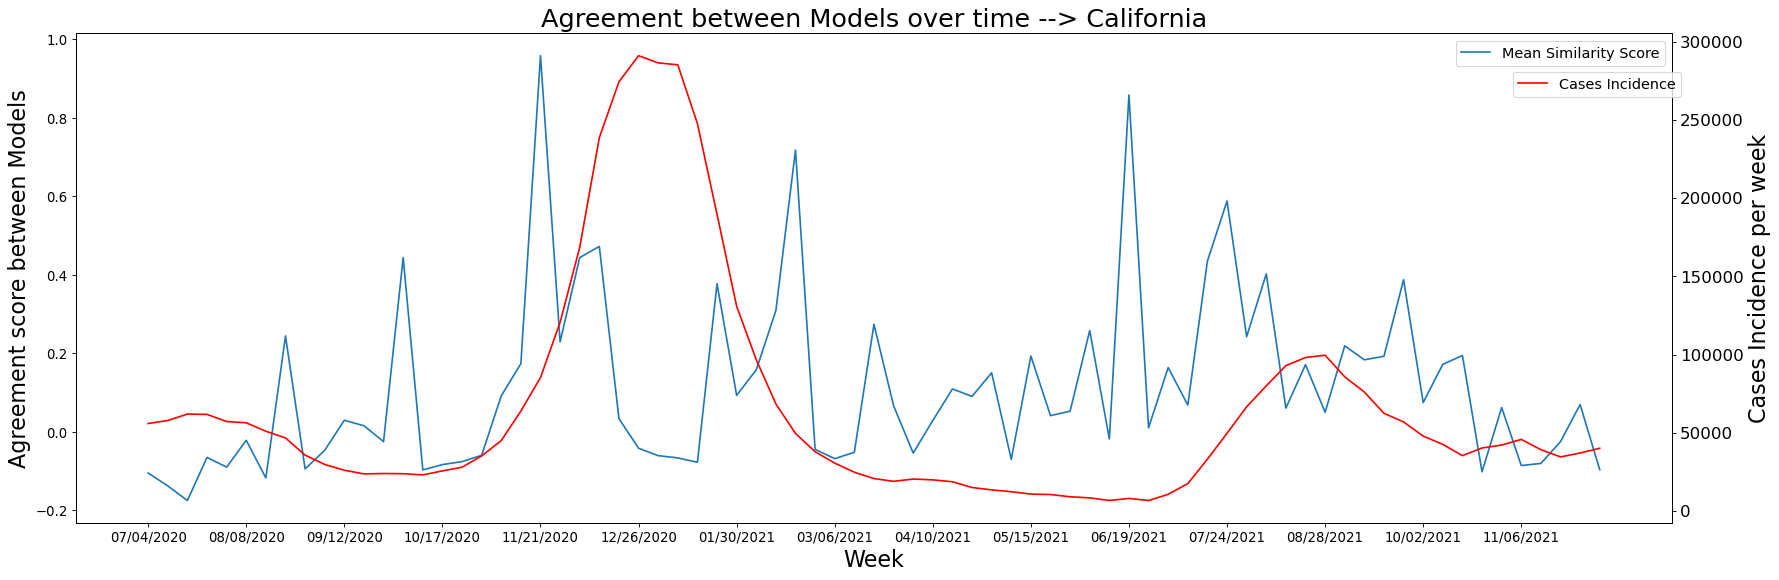

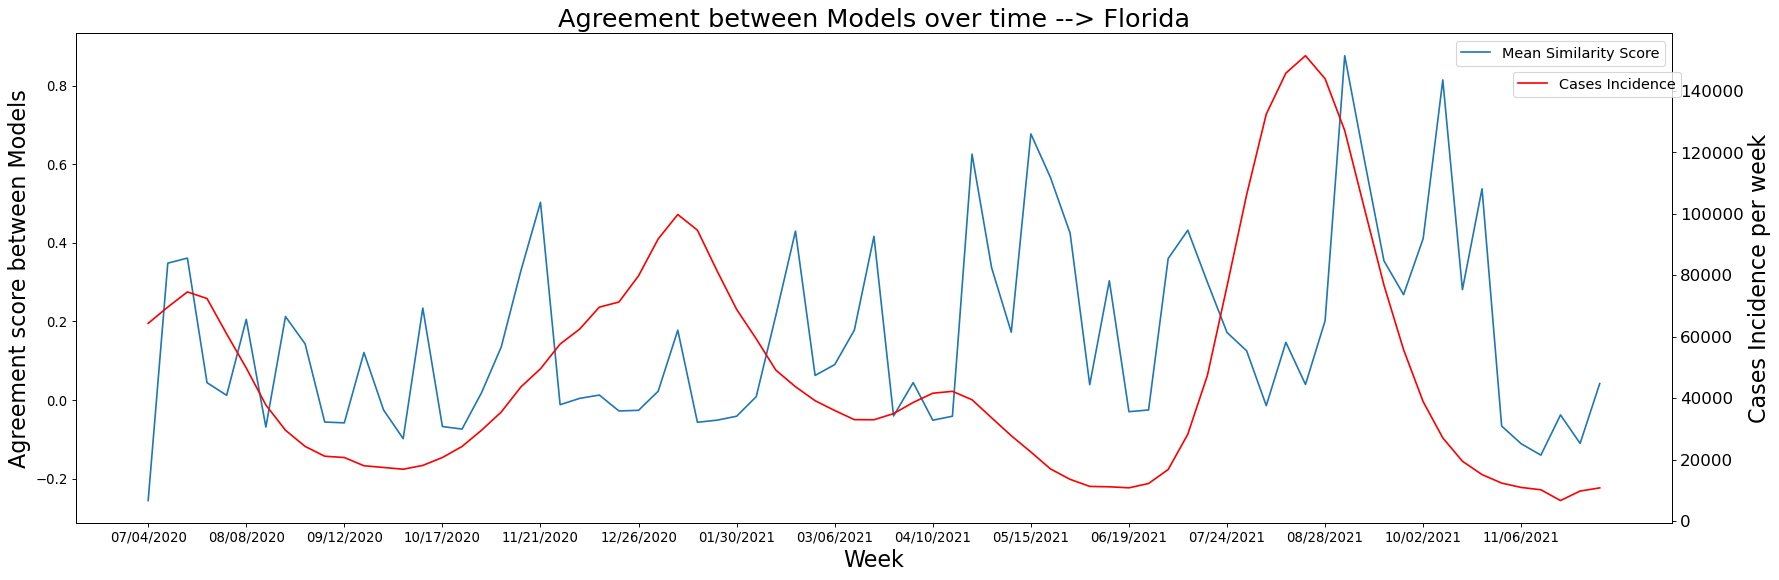

In [328]:
def date_formatting(week_nbr):
# week_nbr = 164
    t = 'Jan 22 2020'
    format = '%b %d %Y'
    now = datetime.strptime(t,format)
    after = now + timedelta(days = int(week_nbr))
    return after.date().strftime("%m/%d/%Y")
State_list_1 = list(MeanSimilarityModels_viz.location.unique())

for state in State_list_1:
    fig, axs = plt.subplots(1,figsize=(24,10 ), dpi=80)

    fig.tight_layout(pad=13.0)

    
    ### Model data extraction for mean aggrement score
    subset = MeanSimilarityModels_viz[MeanSimilarityModels_viz['location']==state]
    
    Incidence_x = subset['Week_nbr'].to_list()
    Incidence_y = subset['Week_Count'].to_list()
    
    str_week_int = []
    str_week = []
    for i in range(0,len(Incidence_x),5):
        str_week_int.append(Incidence_x[i])
        str_week.append(date_formatting(Incidence_x[i]))

    a2 = axs.twinx()
    q = a2.plot(Incidence_x,Incidence_y,label=Runtype+" Incidence",color="red")
    a2.set_ylabel(Runtype+' Incidence per week', fontsize = 20)
    
    a2.set_xticks(str_week_int)
    a2.set_xticklabels(str_week,rotation=40,fontsize=15)
    a2.yaxis.set_tick_params(labelsize=15)
    
    
    subset = MeanSimilarityModels_viz[MeanSimilarityModels_viz['location']==state]

    week_nbrs = list(subset['Week_nbr'].values)

    meanS_miliary = subset['Mean_Similarity'].values
    
    b = axs.plot(week_nbrs,meanS_miliary,label="Mean Similarity Score")
    axs.set_xlabel('Week', fontsize = 20)
    axs.set_ylabel('Agreement score between Models', fontsize = 20)
    axs.yaxis.set_tick_params(labelsize='large')
    axs.xaxis.set_tick_params(labelsize='large')
#     axs.xtick.labelsize(20)
#     axs.xaxis.set_size(20)
#     axs.set_yticklabels(fontsize=13)

#     axs[1].set(xlabel="Week Number", ylabel="Agreement score between Models")

    axs.set_title("Agreement between Models over time --> "+state,fontsize=23)
    
    leg1 = axs.legend(loc='upper right',prop={'size': 13})
    leg1 = a2.legend(loc=(0.90, 0.87),prop={'size': 13})
    
    
    

## 2) Covid-hub ensemble and Shapelet ensemble cosine score plotted against time

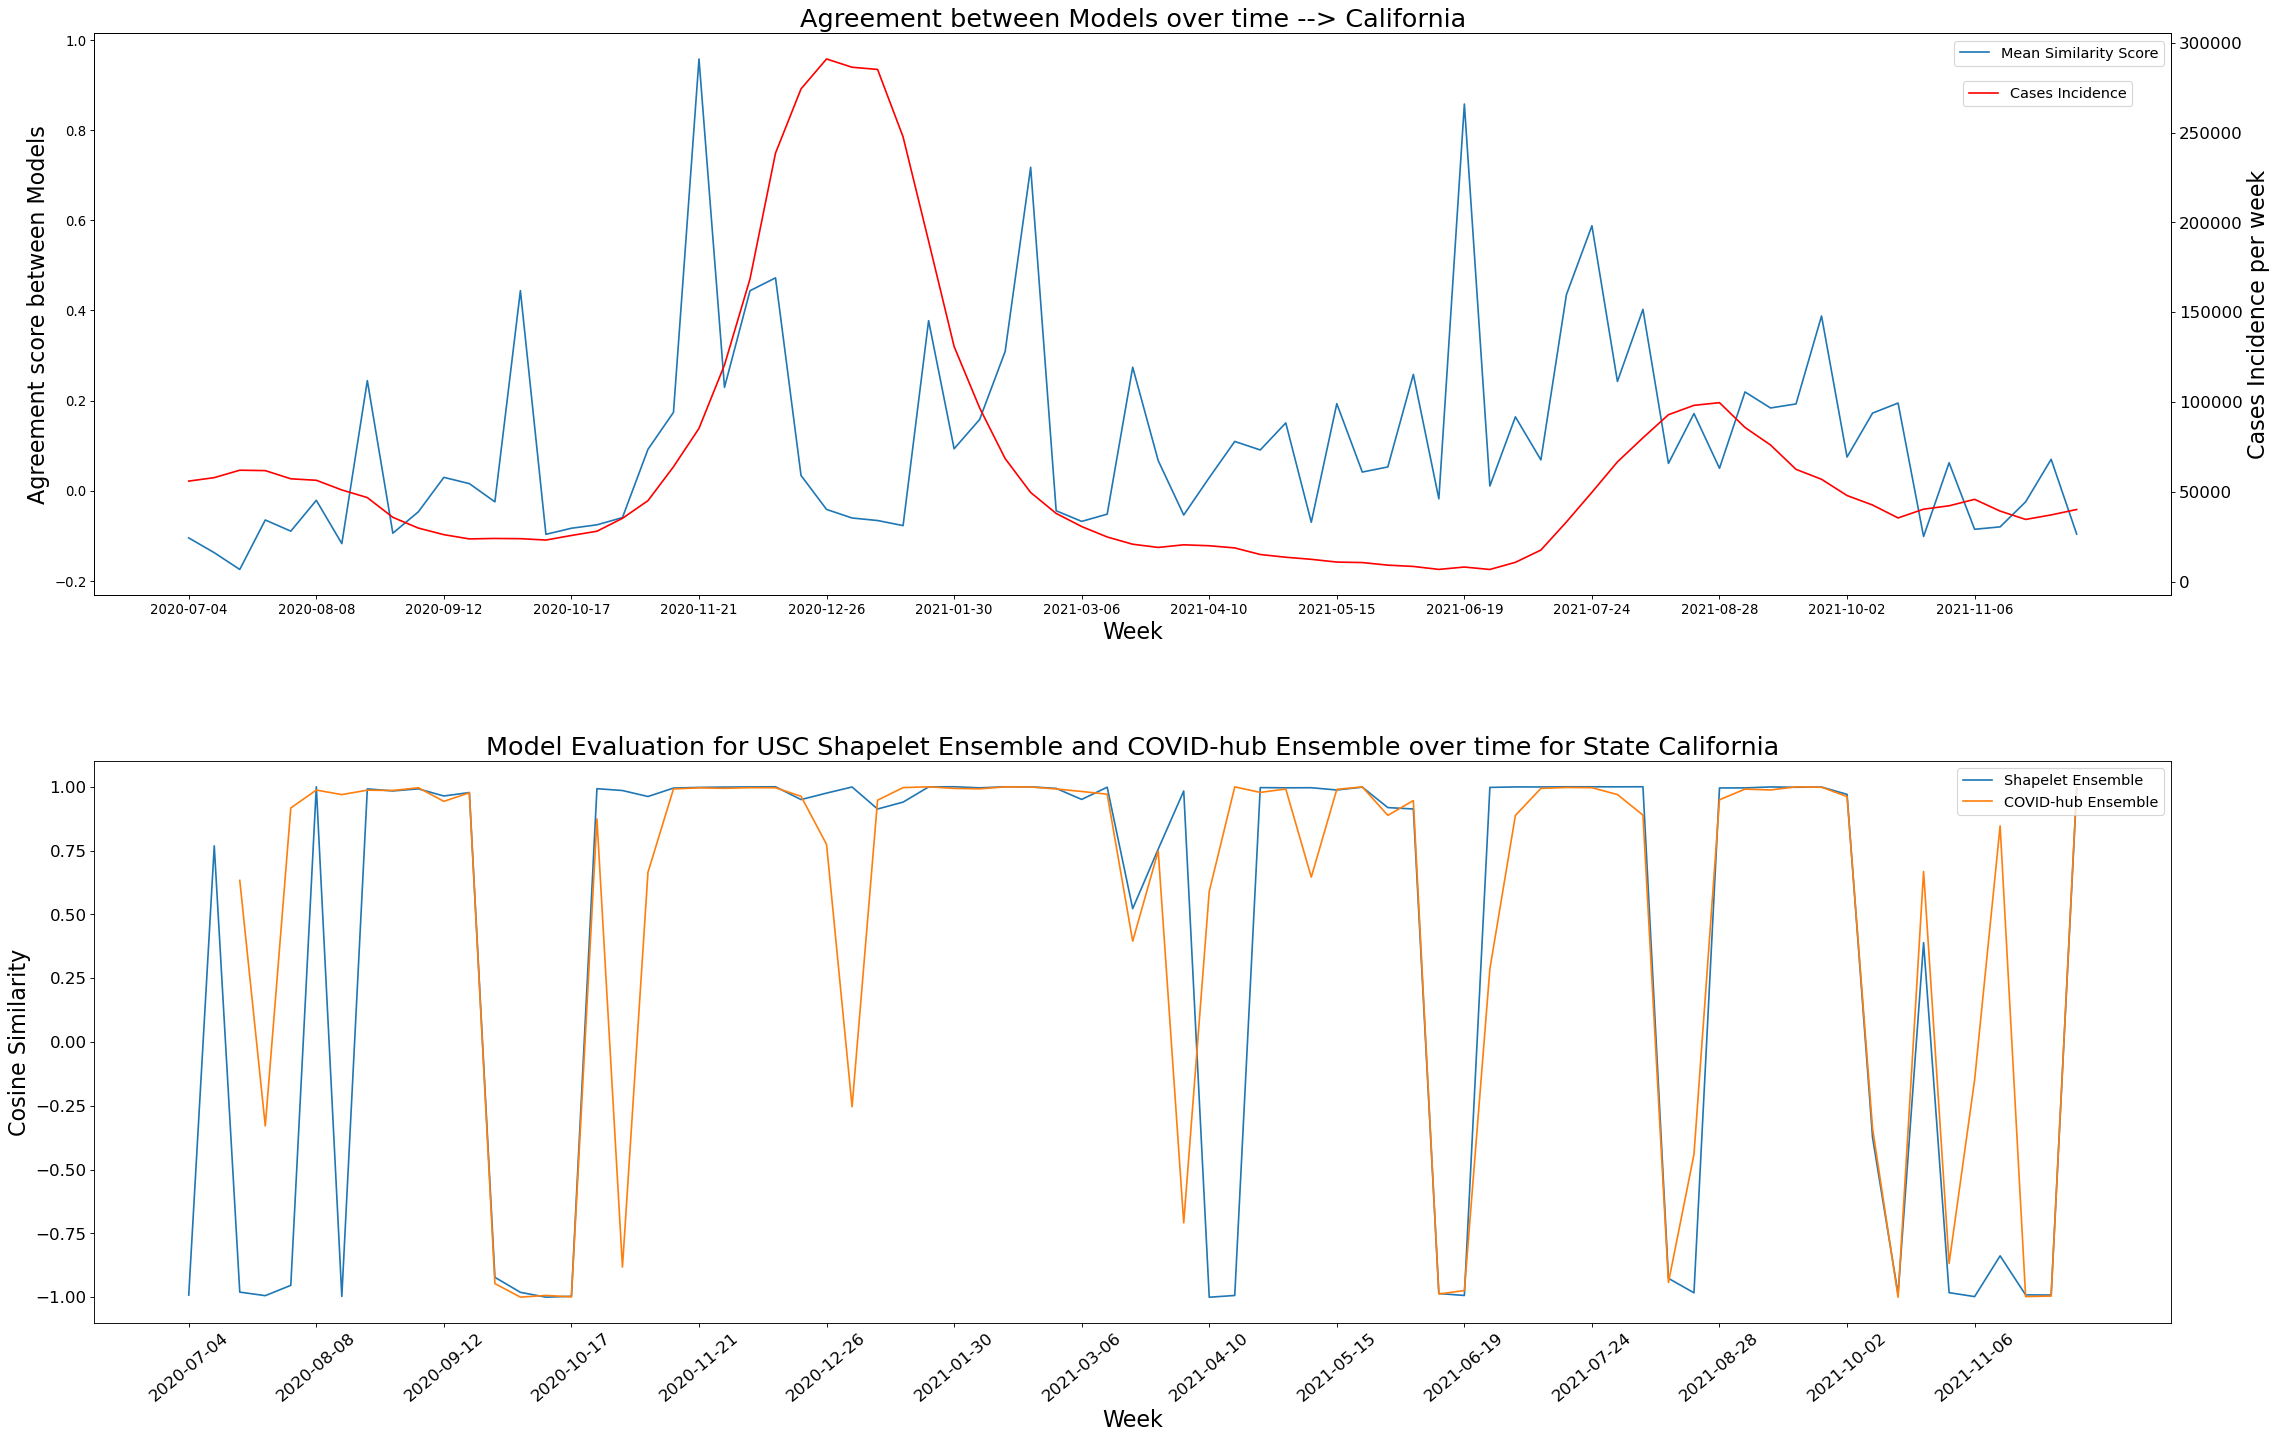

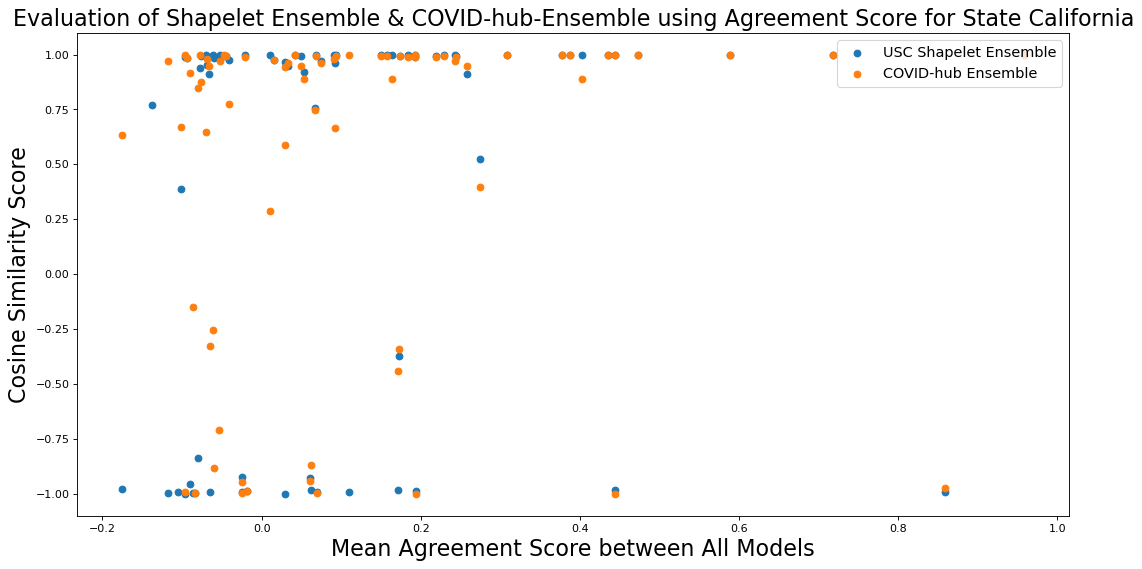

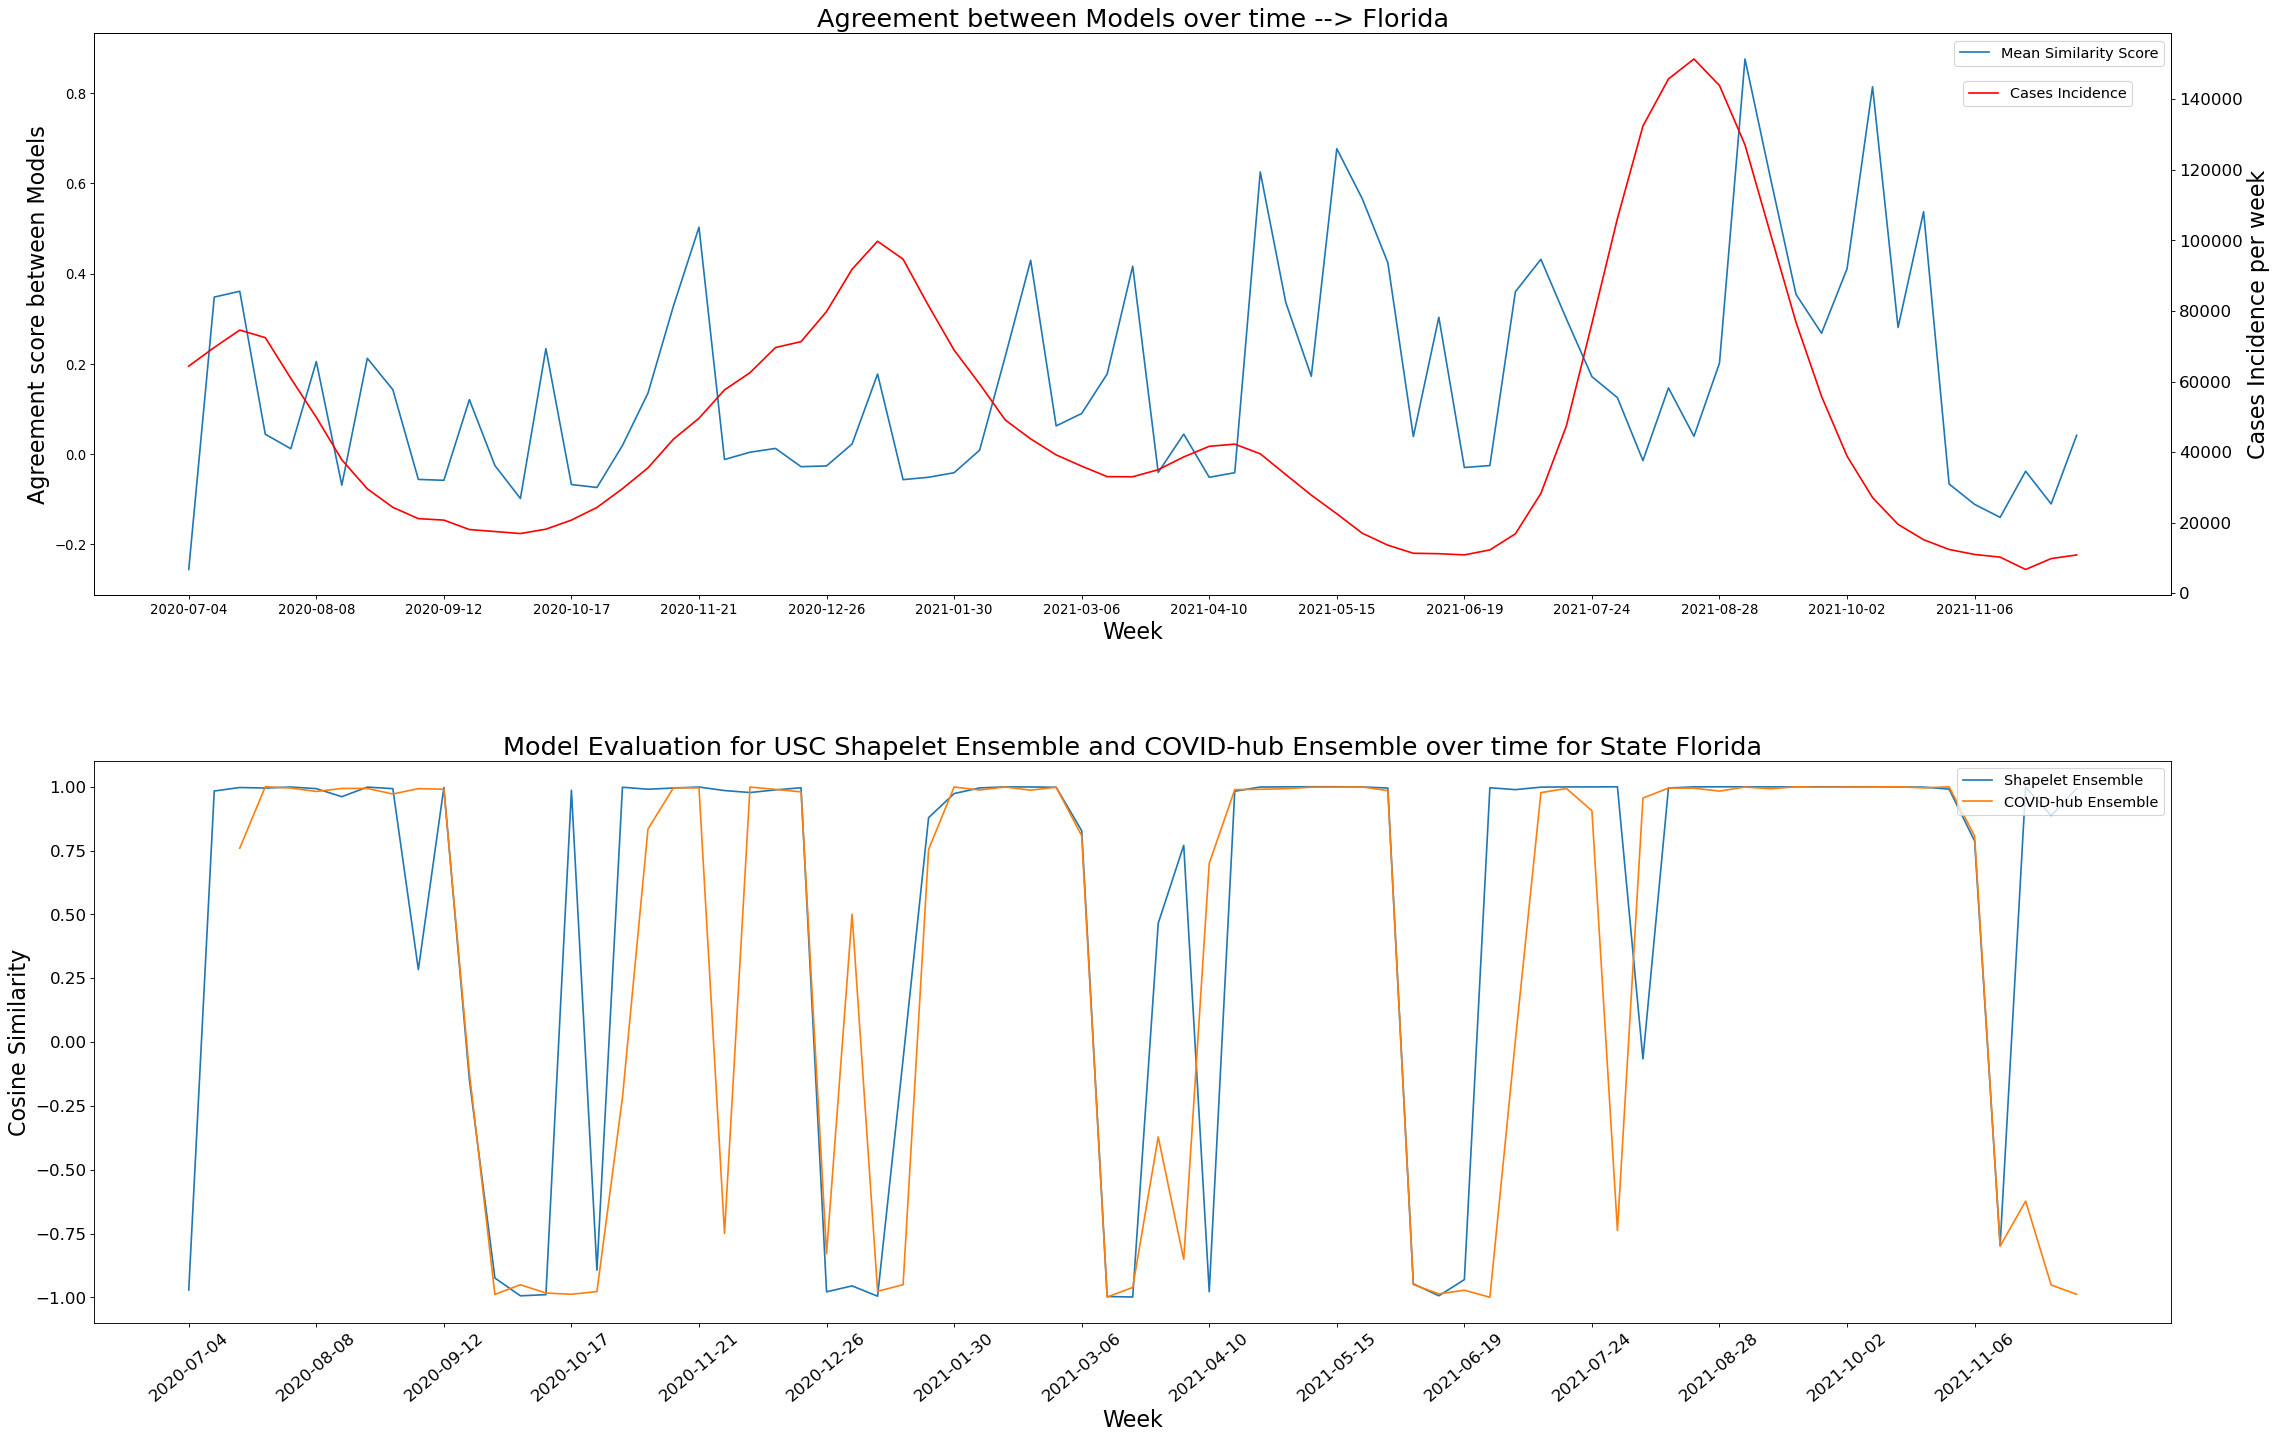

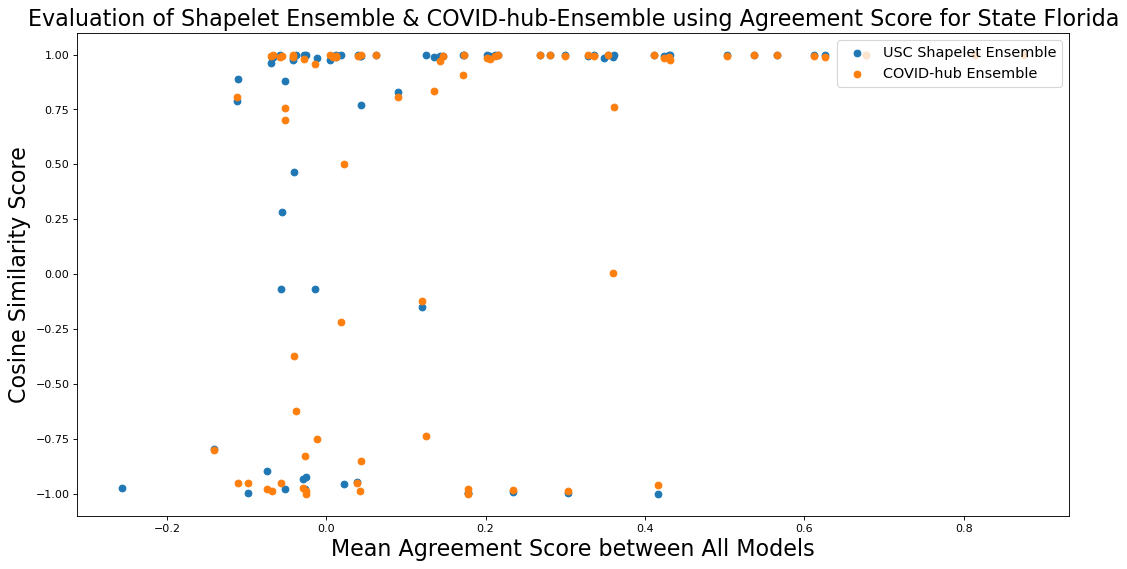

In [346]:
State_list_1 = list(MeanSimilarityModels_viz.location.unique())

for state in State_list_1:
    
    scatter_plot_x = None
    
    Scatter_plot_y1 = None
    
    Scatter_plot_y2 = None
    fig, axs = plt.subplots(2,figsize=(30,20 ), dpi=80)

    fig.tight_layout(pad=13.0)

 ################ Shapelet Ensemble / CovidHub_Ensemble Plots ###############    
    ### Model data extraction for mean aggrement score
    subset = MeanSimilarityModels_viz[MeanSimilarityModels_viz['location']==state]
    
    Incidence_x = subset['Week_nbr'].to_list()
    Incidence_y = subset['Week_Count'].to_list()
    
    str_week_int = []
    str_week = []
    for i in range(0,len(Incidence_x),5):
        str_week_int.append(Incidence_x[i])
        str_week.append(date_formatting(Incidence_x[i]))

    a2 = axs[0].twinx()
    q = a2.plot(Incidence_x,Incidence_y,label=Runtype+" Incidence",color="red")
    a2.set_ylabel(Runtype+' Incidence per week', fontsize = 20)
    
    a2.set_xticks(str_week_int)
    a2.set_xticklabels(str_week,rotation=40,fontsize=15)
    a2.yaxis.set_tick_params(labelsize=15)
    
    
    subset = MeanSimilarityModels_viz[MeanSimilarityModels_viz['location']==state]

    week_nbrs = list(subset['Week_nbr'].values)

    meanS_miliary = subset['Mean_Similarity'].values
    scatter_plot_x = [week_nbrs,meanS_miliary]
    
    b = axs[0].plot(week_nbrs,meanS_miliary,label="Mean Similarity Score")
    axs[0].set_xlabel('Week', rotation=0,fontsize=20)
    axs[0].set_ylabel('Agreement score between Models', fontsize = 20)
    axs[0].yaxis.set_tick_params(labelsize='large')
    axs[0].xaxis.set_tick_params(labelsize='large')
#     axs.xtick.labelsize(20)
#     axs.xaxis.set_size(20)
#     axs.set_yticklabels(fontsize=13)

#     axs[1].set(xlabel="Week Number", ylabel="Agreement score between Models")

    axs[0].set_title("Agreement between Models over time --> "+state,fontsize=23)
    
    leg1 = axs[0].legend(loc='upper right',prop={'size': 13})
    leg1 = a2.legend(loc=(0.90, 0.87),prop={'size': 13})
    

    ################ Shapelet Ensemble / CovidHub_Ensemble Plots ###############
    
    
    ### USC Shapelet Subset
    
    subset_shapelet = Shapelet_ensemble_data[Shapelet_ensemble_data['Location']==state]
    x1 = subset_shapelet['Week_nbr'].to_list()
    
#     print("Shapelet Week cnt",len(x1))
    y = subset_shapelet['Shapelet_Ensemble_Score'].to_list()
    
    usc = axs[1].plot(x1,y,label='Shapelet Ensemble')
    scatter_plot_y1 = [x1,y]

    str_week_int = []
    str_week = []
    for i in range(0,len(x1),5):
        str_week_int.append(x1[i])
        str_week.append(date_formatting(x1[i]))
    axs[1].set_xticks(str_week_int)
    axs[1].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)

    axs[1].set_xlabel('Week', fontsize = 20)
    axs[1].set_ylabel('Cosine Similarity', fontsize = 20)
    
    
    usc = axs[1].set(xlabel="Week", ylabel="Cosine Similarity",label = "USC Shapelet Ensemble")

    axs[1].set_title("Model Evaluation for USC Shapelet Ensemble and COVID-hub Ensemble over time for State {}".format(state),fontsize=23)
#         plt.show()

    subset = Model_VS_Actual_DF_cosine[Model_VS_Actual_DF_cosine['Location']==state]
    subset_1 = subset[subset['model_name'].isin(['COVIDhub-4_week_ensemble','COVIDhub-ensemble'])].\
                drop_duplicates(['Location','Week_nbr'])
    
    x1 = subset_1['Week_nbr'].values
    
    y1 = subset_1['Cosine_Score'].values
#     print("Ensemble Week cnt",len(x1))
    
    vectors = list(zip(x1,y1))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    ensemble  = axs[1].plot(x,y,label="COVID-hub Ensemble")
#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
    leg1 = axs[1].legend(loc='upper right',prop={'size': 13})
    
    scatter_plot_y2 = [x,y]
    scatter_lookup_dic1 = []
    scatter_lookup_dic2 = []


    for i in range(len(scatter_plot_x[0])):
        x_val_weel = scatter_plot_x[0][i]
        x_val = scatter_plot_x[1][i]
        try:
            y_1 = scatter_plot_y1[1][scatter_plot_y1[0].index(x_val_weel)]
            scatter_lookup_dic1.append((x_val,y_1))
            y_2 = scatter_plot_y2[1][scatter_plot_y2[0].index(x_val_weel)]
            scatter_lookup_dic2.append((x_val,y_2))
        except:
            continue

    
    # perform plotting 
# perform plotting 
    fig, axs = plt.subplots(1,figsize=(16,8 ), dpi=80)

    x1 = [w[0] for w in scatter_lookup_dic1]
    y1 = [w[1] for w in scatter_lookup_dic1]


    usc = axs.scatter(x1,y1,label="USC Shapelet Ensemble")

    x2 = [w[0] for w in scatter_lookup_dic2]
    y2 = [w[1] for w in scatter_lookup_dic2]

    covid_ensemble = axs.scatter(x2,y2,label="COVID-hub Ensemble")

    leg1 = axs.legend(loc='upper right',prop={'size': 13})

    axs.set_xlabel('Mean Agreement Score between All Models', fontsize = 20)
    axs.set_ylabel('Cosine Similarity Score', fontsize = 20)


    #     usc = axs[2].set(xlabel="Week", ylabel="Cosine Similarity",label = "USC Shapelet Ensemble")

    axs.set_title("Evaluation of Shapelet Ensemble & COVID-hub-Ensemble using Agreement Score for State {}".format(state),fontsize=20)
    
    
  

## Evaluation Files Generation

In [331]:
Model_VS_Actual_DF_cosine
def date_formatting(week_nbr):
# week_nbr = 164
    t = 'Jan 22 2020'
    format = '%b %d %Y'
    now = datetime.strptime(t,format)
    after = now + timedelta(days = int(week_nbr))
    return after.date().strftime("%Y-%m-%d")

Model_VS_Actual_DF_cosine['forecast_target_week'] = Model_VS_Actual_DF_cosine['Week_nbr'].apply(date_formatting)



In [332]:
Model_VS_Actual_DF_cosine

,model_name,Location,Week_nbr,Cosine_Score,forecast_target_week
0,JHUAPL-Bucky,California,220,-0.946766,2020-08-29
1,CU-nochange,California,220,-0.988159,2020-08-29
2,COVIDhub-4_week_ensemble,California,220,0.985175,2020-08-29
3,CovidAnalytics-DELPHI,California,220,0.998615,2020-08-29
4,LANL-GrowthRate,California,220,0.980360,2020-08-29
...,...,...,...,...,...
1898,LANL-GrowthRate,Florida,185,0.998042,2020-07-25
1899,Karlen-pypm,Florida,185,-0.999488,2020-07-25
1900,COVIDhub-ensemble,Florida,185,0.999714,2020-07-25
1901,UMich-RidgeTfReg,Florida,185,-0.999417,2020-07-25


In [347]:

Evaluation_file_tmp = Model_VS_Actual_DF_cosine[['model_name','Location','forecast_target_week','Cosine_Score']]
Evaluation_file_tmp.columns = ['Model Name','State','forecast_target_week','Cosine Similarty']

Evaluation_file_tmp['Cosine Similarty'] =Evaluation_file_tmp['Cosine Similarty'].apply(lambda x : round(x,4)) 

In [348]:
iterations = list(Evaluation_file_tmp['State'].unique())
for state in iterations:
    subset = Evaluation_file_tmp[Evaluation_file_tmp['State']==state]
    subset.set_index("Model Name")
    df_evaluation = pd.pivot_table(subset, values = 'Cosine Similarty', index=['Model Name'], columns = 'forecast_target_week').reset_index()
    df_evaluation.fillna("",inplace=True)
    df_evaluation = df_evaluation.set_index("Model Name")
    df_evaluation.index.name = None
    df_evaluation = df_evaluation.rename_axis(None, axis=1)
    if Runtype=='Cases':
        print("Cases")
        df_evaluation.to_csv(Evaluation_files_github+"Cases/scsq_avg_"+state+".csv")
    else:
        df_evaluation.to_csv(Evaluation_files_github+"Deaths/scsq_avg_"+state+".csv")
        
        

Cases
Cases
